# NOAA GEFS Basin Forecasts and Historical Data

This notebook extracts forecast data for each basin centroid from the NOAA GEFS 35-day forecast dataset, fetches corresponding historical weather data using Open-Meteo, and combines them into a single dataset.

## Overview

The process consists of the following steps:
1. Load basin centroid coordinates from a CSV file
2. Connect to the NOAA GEFS forecast dataset
3. Extract forecast data for each basin location using all available initialization times
4. Determine the time range based on forecast data
5. Fetch historical weather data for the same basins and time range
6. Interpolate forecast data to hourly resolution
7. Merge the historical and hourly forecast data into a combined dataset
8. Visualize and analyze the combined forecast and historical data
9. Save the combined hourly data to NetCDF files

In [3]:
# Import required libraries
import os
import sys
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings

# Add src directory to path if it's not already in the path
if '../src' not in sys.path:
    sys.path.append('../src')
from fetch_basin_forecasts import (
    load_basin_centroids,
    fetch_forecasts_for_basins,
    interpolate_to_hourly,
)
from fetch_basin_historical import fetch_historical_for_basins # Import the new function

# Suppress warnings
warnings.filterwarnings('ignore')

## Define Paths for Input and Output Data

In [4]:
# Define paths for input and output data
basin_centroids_file = "../data/basin_centroids.csv"  # File containing basin centroid coordinates
output_dir = "../data/basin_forecasts"  # Directory for output data (for plots only)

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

print(f"Basin centroids file: {basin_centroids_file}")

Basin centroids file: ../data/basin_centroids.csv


## Load Basin Centroids

Load the basin centroid coordinates from the CSV file.

In [5]:
# Load basin centroids
centroids = load_basin_centroids(basin_centroids_file)

# Display the basin coordinates
display(centroids)

Loaded 5 basin centroids from ../data/basin_centroids.csv


,basin_name,latitude,longitude
0,innerste_reservoir_catchment_Basin_0,51.834451,10.307828
1,oker_reservoir_catchment_Basin_0,51.816468,10.447276
2,ecker_reservoir_catchment_Basin_0,51.810056,10.584058
3,soese_reservoir_catchment_Basin_0,51.752310,10.383225
4,grane_reservoir_catchment_Basin_0,51.884391,10.357203


## Load NOAA GEFS Forecast Dataset

Connect to the online NOAA GEFS forecast dataset hosted by dynamical.org.

In [6]:
# Install dependencies if needed
# %pip install "xarray[complete]>=2025.1.2" "zarr>=3.0.4" requests aiohttp

In [7]:
# Load the NOAA GEFS forecast dataset
print("Loading NOAA GEFS dataset...")
ds = xr.open_zarr(
    "https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr?email=optional@email.com", 
    decode_timedelta=True
)

print("\nDataset summary:")
print(f"Time domain: {ds.attrs.get('time_domain', 'N/A')}")
print(f"Forecast domain: {ds.attrs.get('forecast_domain', 'N/A')}")
print(f"Spatial resolution: {ds.attrs.get('spatial_resolution', 'N/A')}")
print(f"\nDataset dimensions:")
for dim, size in ds.dims.items():
    print(f"  {dim}: {size}")

# Show the available initialization times (limited to last 10 for display)
init_times = pd.to_datetime(ds.init_time.values)
print(f"\nTotal number of initialization times: {len(init_times)}")
print(f"First initialization time: {init_times[0].strftime('%Y-%m-%d %H:%M')}")
print(f"Last initialization time: {init_times[-1].strftime('%Y-%m-%d %H:%M')}")

Loading NOAA GEFS dataset...

Dataset summary:
Time domain: Forecasts initialized 2020-10-01 00:00:00 UTC to Present
Forecast domain: Forecast lead time 0-840 hours (0-35 days) ahead
Spatial resolution: 0-240 hours: 0.25 degrees (~20km), 243-840 hours: 0.5 degrees (~40km)

Dataset dimensions:
  init_time: 1658
  ensemble_member: 31
  lead_time: 181
  latitude: 721
  longitude: 1440

Total number of initialization times: 1658
First initialization time: 2020-10-01 00:00
Last initialization time: 2025-04-15 00:00

Dataset summary:
Time domain: Forecasts initialized 2020-10-01 00:00:00 UTC to Present
Forecast domain: Forecast lead time 0-840 hours (0-35 days) ahead
Spatial resolution: 0-240 hours: 0.25 degrees (~20km), 243-840 hours: 0.5 degrees (~40km)

Dataset dimensions:
  init_time: 1658
  ensemble_member: 31
  lead_time: 181
  latitude: 721
  longitude: 1440

Total number of initialization times: 1658
First initialization time: 2020-10-01 00:00
Last initialization time: 2025-04-15 00:

## Extract Forecasts for Basin Centroids

Extract the forecast data for each basin centroid location using all available initialization times.

In [8]:
# Option to limit the number of initialization times for testing or specific analysis
# Uncomment and modify the code below to use specific initialization times

# Use the most recent 5 initialization times to speed up processing
# recent_times = ds.init_time.values[-5:]
# ds_limited = ds.sel(init_time=recent_times)
# print(f"Limited analysis to the {len(recent_times)} most recent initialization times")

# Use all available initialization times for comprehensive analysis
# Set init_time to None to use all available times
init_time = None

# Extract forecasts for all basin centroids
basin_forecasts = fetch_forecasts_for_basins(ds, centroids, init_time)

# Check how many basin forecasts we've extracted
print(f"\nExtracted forecasts for {len(basin_forecasts)} basins")

Extracting forecasts for 5 basins...
Processing basin: innerste_reservoir_catchment_Basin_0 (lat: 51.8345, lon: 10.3078)
Processing basin: oker_reservoir_catchment_Basin_0 (lat: 51.8165, lon: 10.4473)
Processing basin: oker_reservoir_catchment_Basin_0 (lat: 51.8165, lon: 10.4473)
Processing basin: ecker_reservoir_catchment_Basin_0 (lat: 51.8101, lon: 10.5841)
Processing basin: ecker_reservoir_catchment_Basin_0 (lat: 51.8101, lon: 10.5841)
Processing basin: soese_reservoir_catchment_Basin_0 (lat: 51.7523, lon: 10.3832)
Processing basin: soese_reservoir_catchment_Basin_0 (lat: 51.7523, lon: 10.3832)
Processing basin: grane_reservoir_catchment_Basin_0 (lat: 51.8844, lon: 10.3572)
Processing basin: grane_reservoir_catchment_Basin_0 (lat: 51.8844, lon: 10.3572)
Successfully extracted forecasts for 5 basins
Dataset dimensions: {'basin': 5, 'init_time': 1658, 'ensemble_member': 31, 'lead_time': 181}

Extracted forecasts for 21 basins
Successfully extracted forecasts for 5 basins
Dataset dimen

In [9]:
basin_forecasts

<xarray.Dataset> Size: 4GB
Dimensions:                                     (basin: 5, init_time: 1658,
                                                 ensemble_member: 31,
                                                 lead_time: 181)
Coordinates:
  * ensemble_member                             (ensemble_member) uint16 62B ...
    expected_forecast_length                    (init_time) timedelta64[ns] 13kB dask.array<chunksize=(1658,), meta=np.ndarray>
    ingested_forecast_length                    (init_time, ensemble_member) timedelta64[ns] 411kB dask.array<chunksize=(1658, 31), meta=np.ndarray>
  * init_time                                   (init_time) datetime64[ns] 13kB ...
    latitude                                    (basin) float64 40B 51.75 ......
  * lead_time                                   (lead_time) timedelta64[ns] 1kB ...
    longitude                                   (basin) float64 40B 10.25 ......
    spatial_ref                                 int64 8B ...
    valid_time                                  (init_time, lead_time) datetime64[ns] 2MB dask.array<chunksize=(1658, 181), meta=np.ndarray>
  * basin                                       (basin) <U36 720B 'innerste_r...
Data variables: (12/21)
    categorical_freezing_rain_surface           (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    categorical_ice_pellets_surface             (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    categorical_rain_surface                    (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    categorical_snow_surface                    (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    downward_long_wave_radiation_flux_surface   (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    downward_short_wave_radiation_flux_surface  (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    ...                                          ...
    temperature_2m                              (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    total_cloud_cover_atmosphere                (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    wind_u_100m                                 (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    wind_u_10m                                  (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    wind_v_100m                                 (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    wind_v_10m                                  (basin, init_time, ensemble_member, lead_time) float32 186MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
Attributes:
    dataset_id:           noaa-gefs-forecast-35-day
    dataset_version:      0.2.0
    name:                 NOAA GEFS forecast, 35 day
    description:          Weather forecasts from the Global Ensemble Forecast...
    attribution:          NOAA NWS NCEP GEFS data processed by dynamical.org ...
    spatial_domain:       Global
    spatial_resolution:   0-240 hours: 0.25 degrees (~20km), 243-840 hours: 0...
    time_domain:          Forecasts initialized 2020-10-01 00:00:00 UTC to Pr...
    time_resolution:      Forecasts initialized every 24 hours.
    forecast_domain:      Forecast lead time 0-840 hours (0-35 days) ahead
    forecast_resolution:  Forecast step 0-240 hours: 3 hourly, 243-840 hours:...

## Fetch Historical Data

Fetch historical weather data from Open-Meteo for the same basins. The time range will match the forecast initialization times to ensure alignment.

In [10]:
# Determine the date range from the forecast data
start_date_hist = pd.to_datetime(basin_forecasts.init_time.min().values).strftime('%Y-%m-%d')
end_date_hist = pd.to_datetime(basin_forecasts.init_time.max().values).strftime('%Y-%m-%d')
print(f"Historical data range determined by forecast init_times: {start_date_hist} to {end_date_hist}")

# Define historical variables (can customize)
historical_variables = [
    "temperature_2m", "relative_humidity_2m", "precipitation", "rain", "snowfall", 
    "soil_moisture_0_to_7cm", "soil_moisture_7_to_28cm", "soil_moisture_28_to_100cm", 
    "soil_moisture_100_to_255cm", "et0_fao_evapotranspiration", "surface_pressure", 
    "snow_depth_water_equivalent"
]

# Fetch historical data
basin_historical_data = fetch_historical_for_basins(centroids, start_date_hist, end_date_hist, historical_variables)

# Display historical data summary
if basin_historical_data:
    display(basin_historical_data)
else:
    print("Failed to fetch historical data.")

Historical data range determined by forecast init_times: 2020-10-01 to 2025-04-15
Fetching historical data from 2020-10-01 to 2025-04-15 for 5 basins...
  Fetching data for: innerste_reservoir_catchment_Basin_0 (Lat: 51.8345, Lon: 10.3078)
  Fetching data for: oker_reservoir_catchment_Basin_0 (Lat: 51.8165, Lon: 10.4473)
  Fetching data for: ecker_reservoir_catchment_Basin_0 (Lat: 51.8101, Lon: 10.5841)
  Fetching data for: soese_reservoir_catchment_Basin_0 (Lat: 51.7523, Lon: 10.3832)
  Fetching data for: grane_reservoir_catchment_Basin_0 (Lat: 51.8844, Lon: 10.3572)
Successfully fetched and combined historical data for 5 basins.
Historical Dataset dimensions: {'basin': 5, 'time': 39792}


<xarray.Dataset> Size: 10MB
Dimensions:                      (basin: 5, time: 39792)
Coordinates:
  * time                         (time) datetime64[ns] 318kB 2020-10-01 ... 2...
  * basin                        (basin) <U36 720B 'innerste_reservoir_catchm...
Data variables:
    temperature_2m               (basin, time) float32 796kB 10.82 10.27 ... nan
    relative_humidity_2m         (basin, time) float32 796kB 92.3 91.96 ... nan
    precipitation                (basin, time) float32 796kB 0.0 0.0 ... nan nan
    rain                         (basin, time) float32 796kB 0.0 0.0 ... nan nan
    snowfall                     (basin, time) float32 796kB 0.0 0.0 ... nan nan
    soil_moisture_0_to_7cm       (basin, time) float32 796kB 0.356 0.356 ... nan
    soil_moisture_7_to_28cm      (basin, time) float32 796kB 0.349 0.349 ... nan
    soil_moisture_28_to_100cm    (basin, time) float32 796kB 0.307 0.307 ... nan
    soil_moisture_100_to_255cm   (basin, time) float32 796kB 0.352 0.352 ... nan
    et0_fao_evapotranspiration   (basin, time) float32 796kB 0.0 0.0 ... nan nan
    surface_pressure             (basin, time) float32 796kB 953.2 952.8 ... nan
    snow_depth_water_equivalent  (basin, time) float32 796kB nan nan ... nan nan
Attributes:
    latitude:               51.845340728759766
    longitude:              10.365631103515625
    elevation:              495.0
    timezone:               None
    timezone_abbreviation:  None
    utc_offset_seconds:     0
    api_source:             https://archive-api.open-meteo.com/v1/archive
    api_model:              best_match

## Interpolate Forecasts to Hourly Resolution

The NOAA GEFS forecast dataset provides data at varying temporal resolutions:
- For the first 240 hours (10 days): Data is available at 3-hour intervals
- For hours 243-840 (days 11-35): Data is available at 6-hour intervals

This results in 181 lead time steps over the 35-day forecast period.

We interpolate the forecast values to hourly resolution for the first 10 days (240 hours) using linear interpolation. This provides higher temporal granularity for merging with hourly historical data.

In [11]:
# Apply linear interpolation to convert forecast data to hourly resolution for the first 10 days
print("Interpolating forecast data to hourly resolution for the first 10 days...")

# Process the dataset to get hourly resolution
basin_forecasts_hourly = interpolate_to_hourly(basin_forecasts, max_hours=240)

# Show the new dataset's time dimension
print(f"\nOriginal forecast lead_times: {len(basin_forecasts.lead_time)} steps")
print(f"Hourly forecast lead_times: {len(basin_forecasts_hourly.lead_time)} steps")

# Compare the resolution before and after
print("\nOriginal forecast lead_time resolution (first 24 hours):")
print(basin_forecasts.lead_time[:9].values)

print("\nNew hourly forecast lead_time resolution (first 24 hours):")
print(basin_forecasts_hourly.lead_time[:25].values)

# Compare dataset dimensions
print(f"\nOriginal forecast dimensions: {dict(basin_forecasts.dims)}")
print(f"Hourly forecast dimensions: {dict(basin_forecasts_hourly.dims)}")

# Preview the hourly forecast dataset
basin_forecasts_hourly

Interpolating forecast data to hourly resolution for the first 10 days...

Original forecast lead_times: 181 steps
Hourly forecast lead_times: 240 steps

Original forecast lead_time resolution (first 24 hours):
[             0 10800000000000 21600000000000 32400000000000
 43200000000000 54000000000000 64800000000000 75600000000000
 86400000000000]

New hourly forecast lead_time resolution (first 24 hours):
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]

Original forecast dimensions: {'basin': 5, 'init_time': 1658, 'ensemble_member': 31, 'lead_time': 181}
Hourly forecast dimensions: {'basin': 5, 'init_time': 1658, 'ensemble_member': 31, 'lead_time': 240}

Original forecast lead_times: 181 steps
Hourly forecast lead_times: 240 steps

Original forecast lead_time resolution (first 24 hours):
[             0 10800000000000 21600000000000 32400000000000
 43200000000000 54000000000000 64800000000000 75600000000000
 86400000000000]

New hourly forecast lead_time 

<xarray.Dataset> Size: 5GB
Dimensions:                                     (basin: 5, init_time: 1658,
                                                 ensemble_member: 31,
                                                 lead_time: 240)
Coordinates:
  * ensemble_member                             (ensemble_member) uint16 62B ...
    expected_forecast_length                    (init_time) timedelta64[ns] 13kB dask.array<chunksize=(1658,), meta=np.ndarray>
    ingested_forecast_length                    (init_time, ensemble_member) timedelta64[ns] 411kB dask.array<chunksize=(1658, 31), meta=np.ndarray>
  * init_time                                   (init_time) datetime64[ns] 13kB ...
    latitude                                    (basin) float64 40B 51.75 ......
    longitude                                   (basin) float64 40B 10.25 ......
    spatial_ref                                 int64 8B ...
  * basin                                       (basin) <U36 720B 'innerste_r...
  * lead_time                                   (lead_time) int64 2kB 1 ... 240
Data variables: (12/21)
    categorical_freezing_rain_surface           (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    categorical_ice_pellets_surface             (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    categorical_rain_surface                    (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    categorical_snow_surface                    (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    downward_long_wave_radiation_flux_surface   (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    downward_short_wave_radiation_flux_surface  (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    ...                                          ...
    temperature_2m                              (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    total_cloud_cover_atmosphere                (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    wind_u_100m                                 (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    wind_u_10m                                  (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    wind_v_100m                                 (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    wind_v_10m                                  (basin, init_time, ensemble_member, lead_time) float32 247MB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
Attributes: (12/15)
    dataset_id:           noaa-gefs-forecast-35-day
    dataset_version:      0.2.0
    name:                 NOAA GEFS forecast, 35 day
    description:          Weather forecasts from the Global Ensemble Forecast...
    attribution:          NOAA NWS NCEP GEFS data processed by dynamical.org ...
    spatial_domain:       Global
    ...                   ...
    forecast_domain:      Forecast lead time 0-840 hours (0-35 days) ahead
    forecast_resolution:  Forecast step 0-240 hours: 3 hourly, 243-840 hours:...
    interpolation:        Linear interpolation to hourly resolution
    original_resolution:  3-hourly for first 10 days
    max_forecast_hours:   240
    lead_time_format:     Integer hours from 1 to 240

## Merge Historical and Forecast Data

Combine the fetched historical data and the interpolated hourly forecast data into a single xarray Dataset. The forecast `init_time` coordinate is renamed to `time` to align with the historical data.

In [15]:
# Rename 'init_time' in forecast data to 'time' for merging
basin_forecasts_hourly_renamed = basin_forecasts_hourly.rename({'init_time': 'time'})

# --- Find the latest forecast initialization time BEFORE merging ---
latest_forecast_init_time = pd.to_datetime(basin_forecasts_hourly_renamed['time'].max().item())
print(f"Latest Forecast Initialization Time (UTC): {latest_forecast_init_time.strftime('%Y-%m-%d %H:%M:%S')}")
# ---

# Identify conflicting variable names (present in both historical and forecast)
# Ensure basin_historical_data is not None before accessing data_vars
conflicting_vars = []
if basin_historical_data is not None:
    conflicting_vars = [var for var in basin_historical_data.data_vars if var in basin_forecasts_hourly_renamed.data_vars]

# Rename conflicting variables in the historical dataset
rename_dict = {var: f"{var}_hist" for var in conflicting_vars}
basin_historical_data_renamed = basin_historical_data.rename(rename_dict) if basin_historical_data is not None else None
if rename_dict:
    print(f"Renamed conflicting historical variables: {list(rename_dict.values())}")

# Merge the historical and forecast datasets using 'no_conflicts'
print("Merging historical and forecast datasets...")
if basin_historical_data_renamed is not None:
    try:
        basin_forecast_historical_hourly = xr.merge([basin_historical_data_renamed, basin_forecasts_hourly_renamed], compat='no_conflicts')
        print("\nMerge successful.")
        print(f"Combined Dataset dimensions: {dict(basin_forecast_historical_hourly.dims)}")
        # Display variable names to confirm merge
        print("\nVariables in combined dataset:")
        for var_name in basin_forecast_historical_hourly.data_vars:
             print(f"  - {var_name}: {basin_forecast_historical_hourly[var_name].dims}")
        display(basin_forecast_historical_hourly)
    except Exception as e:
        print(f"\nMerge failed: {e}")
        # Fallback or further error handling
        basin_forecast_historical_hourly = None
else:
    print("Skipping merge as historical data failed to load or was not renamed.")
    basin_forecast_historical_hourly = basin_forecasts_hourly_renamed 
    print("Proceeding with only forecast data.")

Latest Forecast Initialization Time (UTC): 2025-04-15 00:00:00
Renamed conflicting historical variables: ['temperature_2m_hist', 'relative_humidity_2m_hist']
Merging historical and forecast datasets...

Merge successful.
Combined Dataset dimensions: {'time': 39792, 'basin': 5, 'ensemble_member': 31, 'lead_time': 240}

Variables in combined dataset:
  - temperature_2m_hist: ('basin', 'time')
  - relative_humidity_2m_hist: ('basin', 'time')
  - precipitation: ('basin', 'time')
  - rain: ('basin', 'time')
  - snowfall: ('basin', 'time')
  - soil_moisture_0_to_7cm: ('basin', 'time')
  - soil_moisture_7_to_28cm: ('basin', 'time')
  - soil_moisture_28_to_100cm: ('basin', 'time')
  - soil_moisture_100_to_255cm: ('basin', 'time')
  - et0_fao_evapotranspiration: ('basin', 'time')
  - surface_pressure: ('basin', 'time')
  - snow_depth_water_equivalent: ('basin', 'time')
  - categorical_freezing_rain_surface: ('basin', 'time', 'ensemble_member', 'lead_time')
  - categorical_ice_pellets_surface: (

<xarray.Dataset> Size: 124GB
Dimensions:                                     (time: 39792, basin: 5,
                                                 ensemble_member: 31,
                                                 lead_time: 240)
Coordinates:
  * time                                        (time) datetime64[ns] 318kB 2...
  * basin                                       (basin) <U36 720B 'innerste_r...
  * ensemble_member                             (ensemble_member) uint16 62B ...
  * lead_time                                   (lead_time) int64 2kB 1 ... 240
    expected_forecast_length                    (time) timedelta64[ns] 318kB dask.array<chunksize=(1658,), meta=np.ndarray>
    ingested_forecast_length                    (time, ensemble_member) timedelta64[ns] 10MB dask.array<chunksize=(1658, 31), meta=np.ndarray>
    latitude                                    (basin) float64 40B 51.75 ......
    longitude                                   (basin) float64 40B 10.25 ......
    spatial_ref                                 int64 8B ...
Data variables: (12/33)
    temperature_2m_hist                         (basin, time) float32 796kB 1...
    relative_humidity_2m_hist                   (basin, time) float32 796kB 9...
    precipitation                               (basin, time) float32 796kB 0...
    rain                                        (basin, time) float32 796kB 0...
    snowfall                                    (basin, time) float32 796kB 0...
    soil_moisture_0_to_7cm                      (basin, time) float32 796kB 0...
    ...                                          ...
    temperature_2m                              (basin, time, ensemble_member, lead_time) float32 6GB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    total_cloud_cover_atmosphere                (basin, time, ensemble_member, lead_time) float32 6GB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    wind_u_100m                                 (basin, time, ensemble_member, lead_time) float32 6GB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    wind_u_10m                                  (basin, time, ensemble_member, lead_time) float32 6GB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    wind_v_100m                                 (basin, time, ensemble_member, lead_time) float32 6GB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
    wind_v_10m                                  (basin, time, ensemble_member, lead_time) float32 6GB dask.array<chunksize=(1, 1, 16, 240), meta=np.ndarray>
Attributes:
    latitude:               51.845340728759766
    longitude:              10.365631103515625
    elevation:              495.0
    timezone:               None
    timezone_abbreviation:  None
    utc_offset_seconds:     0
    api_source:             https://archive-api.open-meteo.com/v1/archive
    api_model:              best_match

## Visualize Combined Historical and Forecast Data

Plot the historical data for the two weeks leading up to the latest forecast initialization time, followed by the ensemble forecast (median, uncertainty band, and individual members) for temperature and precipitation.

Using Latest Forecast Initialization Time (UTC): 2025-04-15 00:00:00
Historical data window (UTC): 2025-04-01 00:00 to 2025-04-15 00:00:00
Loading data for plotting...
Data loaded.
Plotting ensemble members (can be slow)...
Finished plotting members.
Plotting precipitation ensemble members...
Finished plotting precipitation members.


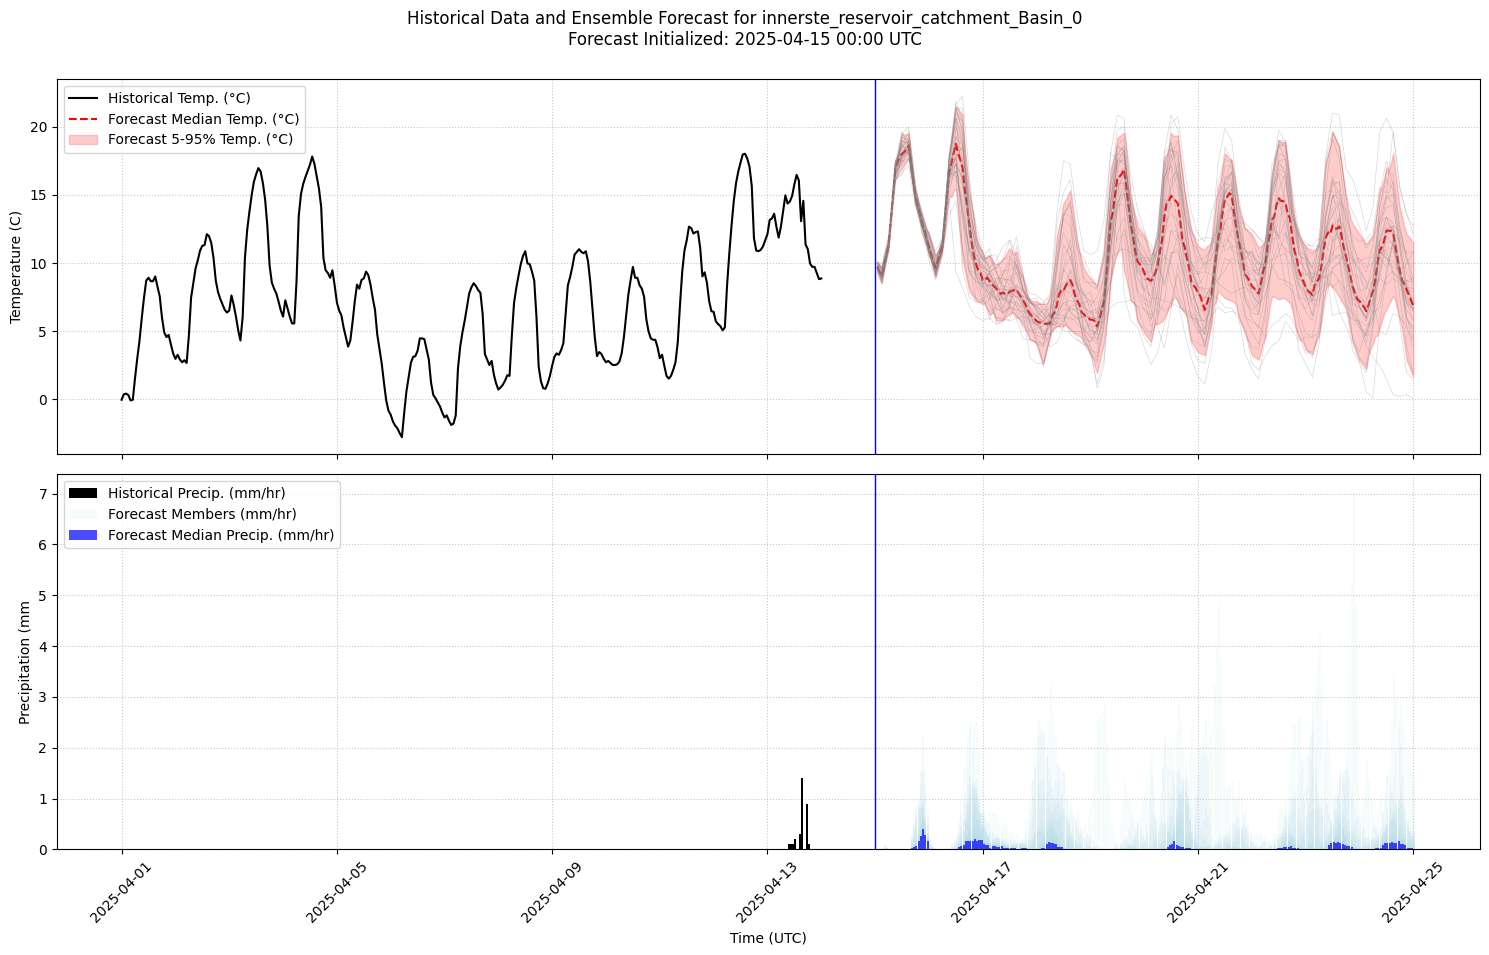

In [28]:
# Visualization settings
selected_basin = basin_forecast_historical_hourly['basin'].values[0] # Select the first basin for plotting
historical_days = 14 # Number of historical days to show before the forecast
uncertainty_quantiles = [0.05, 0.95] # Quantiles for uncertainty band
# PERFORMANCE NOTE: Setting show_members to False significantly speeds up plotting.
show_members = True # Whether to plot individual ensemble members 
# Use the renamed historical variable names
historical_temp_var = 'temperature_2m_hist' # Historical temperature variable name
historical_precip_var = 'precipitation' # Historical precipitation variable name
# Forecast variable names remain the same
forecast_temp_var = 'temperature_2m' # Forecast temperature variable name
forecast_precip_var = 'precipitation_surface' # Forecast precipitation variable name

# Check if the combined dataset exists and has the necessary coordinates/variables
# Also check if the latest_forecast_init_time variable exists from the previous cell
if 'basin_forecast_historical_hourly' in locals() and basin_forecast_historical_hourly is not None and 'latest_forecast_init_time' in locals():
    # Select data for the chosen basin
    basin_data = basin_forecast_historical_hourly.sel(basin=selected_basin)
    
    # Use the latest forecast initialization time determined *before* the merge
    print(f"Using Latest Forecast Initialization Time (UTC): {latest_forecast_init_time.strftime('%Y-%m-%d %H:%M:%S')}")
    
    # Define the time window for historical data relative to the forecast init time
    # Historical data ends *just before* the forecast starts
    hist_start_time = latest_forecast_init_time - timedelta(days=historical_days)
    hist_end_time = latest_forecast_init_time # Forecast start time
    print(f"Historical data window (UTC): {hist_start_time.strftime('%Y-%m-%d %H:%M')} to {hist_end_time.strftime('%Y-%m-%d %H:%M:%S')}")
    
    # Extract historical data for the window
    # Ensure the slice range exists in the time coordinate
    try:
        historical_slice = basin_data.sel(time=slice(hist_start_time, hist_end_time))
    except KeyError as e:
        print(f"Warning: Could not select historical time slice: {e}. Check time range.")
        historical_slice = None # Set to None if slice fails
    
    # Extract the latest forecast data using the correct initialization time
    try:
        latest_forecast = basin_data.sel(time=latest_forecast_init_time)
    except KeyError as e:
        print(f"Error: Latest forecast initialization time {latest_forecast_init_time} not found in merged data.")
        latest_forecast = None # Set to None if selection fails
    
    # Proceed only if historical and forecast slices were successfully extracted
    if historical_slice is not None and latest_forecast is not None:
        # Calculate forecast time axis (relative to latest_forecast_init_time)
        forecast_lead_hours = latest_forecast['lead_time'].values
        forecast_time_axis = latest_forecast_init_time + pd.to_timedelta(forecast_lead_hours, unit='h')
        
        # --- Load data for plotting ---
        print("Loading data for plotting...")
        historical_temp_data = None
        historical_precip_data = None
        forecast_median_temp = None
        forecast_quantile_temp = None
        forecast_median_precip = None
        latest_forecast_temp_members = None
        latest_forecast_precip_members = None # Add variable for precip members
        
        if historical_temp_var in historical_slice:
            historical_temp_data = historical_slice[historical_temp_var].load()
        if historical_precip_var in historical_slice:
            # Check if historical precip data is all NaN before loading (might happen with slice issues)
            if not historical_slice[historical_precip_var].isnull().all():
                 historical_precip_data = historical_slice[historical_precip_var].load()
            else:
                 print(f"Warning: Historical precipitation data ('{historical_precip_var}') in the selected slice is all NaN.")
            
        if forecast_temp_var in latest_forecast and 'ensemble_member' in latest_forecast[forecast_temp_var].dims:
            forecast_median_temp = latest_forecast[forecast_temp_var].median(dim='ensemble_member').load()
            forecast_quantile_temp = latest_forecast[forecast_temp_var].quantile(uncertainty_quantiles, dim='ensemble_member').load()
            if show_members:
                 latest_forecast_temp_members = latest_forecast[forecast_temp_var].load() 
        else:
            print(f"Warning: Forecast variable '{forecast_temp_var}' not found or lacks 'ensemble_member' dimension.")
            
        if forecast_precip_var in latest_forecast and 'ensemble_member' in latest_forecast[forecast_precip_var].dims:
            forecast_median_precip = latest_forecast[forecast_precip_var].median(dim='ensemble_member').load()
            if show_members:
                 latest_forecast_precip_members = latest_forecast[forecast_precip_var].load() # Load precip members
        else:
            print(f"Warning: Forecast variable '{forecast_precip_var}' not found or lacks 'ensemble_member' dimension.")
        print("Data loaded.")
        # --- Create Plot ---
        fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
        fig.suptitle(f"Historical Data and Ensemble Forecast for {selected_basin}\nForecast Initialized: {latest_forecast_init_time.strftime('%Y-%m-%d %H:%M UTC')}", y=0.95)
        
        # Plot Temperature
        ax1 = axes[0]
        # Historical Temperature
        if historical_temp_data is not None and not historical_temp_data.isnull().all():
            ax1.plot(historical_temp_data['time'], historical_temp_data.values, label='Historical Temp. (°C)', color='black', linewidth=1.5)
        else:
            print(f"Historical variable '{historical_temp_var}' not found or is all NaN for plotting.")
        
        # Forecast Temperature Median and Uncertainty (if available)
        if forecast_median_temp is not None and forecast_quantile_temp is not None:
            ax1.plot(forecast_time_axis, forecast_median_temp.values, label='Forecast Median Temp. (°C)', color='red', linestyle='--')
            ax1.fill_between(forecast_time_axis, 
                             forecast_quantile_temp.sel(quantile=uncertainty_quantiles[0]).values, 
                             forecast_quantile_temp.sel(quantile=uncertainty_quantiles[1]).values, 
                             color='red', alpha=0.2, label=f'Forecast {uncertainty_quantiles[0]*100:.0f}-{uncertainty_quantiles[1]*100:.0f}% Temp. (°C)')
            # Forecast Temperature Ensemble Members
            if show_members and latest_forecast_temp_members is not None:
                print("Plotting ensemble members (can be slow)...")
                for member_idx, member in enumerate(latest_forecast_temp_members['ensemble_member'].values):
                     ax1.plot(forecast_time_axis, latest_forecast_temp_members.isel(ensemble_member=member_idx).values, color='grey', alpha=0.3, linewidth=0.5)
                print("Finished plotting members.")
                
        ax1.set_ylabel(f"Temperature ({latest_forecast[forecast_temp_var].attrs.get('units', 'N/A') if forecast_temp_var in latest_forecast else 'N/A'})")
        ax1.legend(loc='upper left')
        ax1.grid(True, linestyle=':', alpha=0.7)
        ax1.axvline(latest_forecast_init_time, color='blue', linestyle='-', linewidth=1, label='Forecast Start')
        
        # Plot Precipitation
        ax2 = axes[1]
        forecast_bar_width_days = 1/24 # Define bar width here for use in both median and members
        
        # Historical Precipitation (as bars) - Assumed to be hourly accumulation (mm)
        if historical_precip_data is not None and not historical_precip_data.isnull().all():
            hist_time_diff = np.diff(historical_precip_data['time'].values)
            bar_width_days = (hist_time_diff[0] / np.timedelta64(1, 'D')) if len(hist_time_diff) > 0 else (1/24) 
            ax2.bar(historical_precip_data['time'].values, historical_precip_data.values, width=bar_width_days * 0.9, label='Historical Precip. (mm/hr)', color='black', align='edge', zorder=2)
        else:
            print(f"Historical variable '{historical_precip_var}' not found or is all NaN for plotting.")
        
        # Forecast Precipitation Ensemble Members (as bars) - Plot these first
        if show_members and latest_forecast_precip_members is not None:
            print("Plotting precipitation ensemble members...")
            for member_idx, member in enumerate(latest_forecast_precip_members['ensemble_member'].values):
                 member_precip_data = latest_forecast_precip_members.isel(ensemble_member=member_idx).values
                 # Convert mm/s to mm/hr
                 member_precip_mmhr = member_precip_data * 3600
                 # Plot only the first member's label
                 label = 'Forecast Members (mm/hr)' if member_idx == 0 else None
                 # Use a lower zorder so median plots on top
                 ax2.bar(forecast_time_axis, member_precip_mmhr, width=forecast_bar_width_days * 0.9, color='lightblue', alpha=0.1, align='edge', label=label, zorder=3)
            print("Finished plotting precipitation members.")
            
        # Forecast Precipitation Median (as bars) - Plot this last to be on top
        if forecast_median_precip is not None:
            # Convert mm/s to mm/hr by multiplying by 3600
            forecast_precip_mmhr_median = forecast_median_precip.values * 3600
            # Use a higher zorder
            ax2.bar(forecast_time_axis, forecast_precip_mmhr_median, width=forecast_bar_width_days * 0.9, label='Forecast Median Precip. (mm/hr)', color='blue', alpha=0.7, align='edge', zorder=4)
            
        # Update Y-axis label to reflect hourly accumulation
        ax2.set_ylabel("Precipitation (mm")
        ax2.legend(loc='upper left')
        ax2.grid(True, linestyle=':', alpha=0.7)
        ax2.axvline(latest_forecast_init_time, color='blue', linestyle='-', linewidth=1, zorder=5) # Ensure vertical line is also on top
        
        # Formatting
        plt.xlabel("Time (UTC)")
        plt.xticks(rotation=45)
        plt.tight_layout(rect=[0, 0, 1, 0.95]) 
        plt.show()
    else:
         print("Skipping plot because historical or latest forecast data could not be properly selected.")
else:
    print("Combined dataset 'basin_forecast_historical_hourly' or 'latest_forecast_init_time' not found. Cannot generate plot.")

## Save Combined Hourly Data to NetCDF Files

Save the combined historical and interpolated hourly forecast data for each basin into separate NetCDF files.

In [ ]:
# Define the directory to save the NetCDF files
netcdf_output_dir = os.path.join(output_dir, "historical_forecast_hourly")
os.makedirs(netcdf_output_dir, exist_ok=True)

# Check if the combined dataset exists
if 'basin' in basin_forecast_historical_hourly.coords:
    # Iterate over each basin and save its data to a separate NetCDF file
    for basin_name in basin_forecast_historical_hourly['basin'].values:
        # Select the data for the current basin
        basin_data = basin_forecast_historical_hourly.sel(basin=basin_name)
        
        # Clean attributes: Remove dictionary attributes as they are not NetCDF compatible
        for var in basin_data.variables:
            if hasattr(basin_data[var], 'attrs'):
                attrs_to_delete = [k for k, v in basin_data[var].attrs.items() if isinstance(v, dict)]
                for attr_name in attrs_to_delete:
                    del basin_data[var].attrs[attr_name]
        
        # Also clean dataset-level attributes if necessary
        ds_attrs_to_delete = [k for k, v in basin_data.attrs.items() if isinstance(v, dict)]
        for attr_name in ds_attrs_to_delete:
            del basin_data.attrs[attr_name]
        
        # Construct the output filename
        output_filename = os.path.join(netcdf_output_dir, f"{basin_name}_historical_forecast_hourly.nc")
        
        # Save the data to NetCDF
        try:
            basin_data.to_netcdf(output_filename)
            print(f"Saved combined data for {basin_name} to {output_filename}")
        except Exception as e:
            print(f"Error saving data for {basin_name}: {e}")
        finally:
            basin_data.close()

    print("\nFinished saving all combined basin data to NetCDF files.")
else:
    print("Combined dataset not available for saving.")